<a href="https://colab.research.google.com/github/DanielKorenDataScience/ClassificationProject/blob/main/Classification_Project_Shufersal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Classification Project - SWEETS

for Shufersal on-line orders, for replacing of missing products, will predict the replacement success!

In [9]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import display
p = print
d = display

# Get Data

## Raw Data

In [10]:
id = ''  # name of result file
prefix = 'Shufersal'

RAW = True
DIFF = False
RATIO = False
REL = False

if not DIFF and not RATIO and not REL:
  id = 'no_diff'

In [78]:
fname = 'Sweets.csv'
subdir = ''
data_url = 'https://raw.githubusercontent.com/DanielKorenDataScience/ClassificationProject/main/' + subdir + fname

df1 = pd.read_csv(data_url, nrows=1)
df2 = pd.read_csv(data_url, usecols=[i for i in range(82) if not i in[0,8,10,12,14,16,18,20,24,26,27,48,50,52,54,56,58,62,64,65]])
d(df1)

,OrderNumbert,HouseHoldID,LocationCityName,QuarterNumber,MonthNumber,WeekNumber,DayNumberInWeek,PeriodHoliday,TransactionDate,DepartmentCode,DepartmentName,CategoryCode,CategoryName,GroupCode,GroupName,SubGroupCode,SubGroupName,CompoundID,CompoundIDDesc,ParentProductNumber,ProductDescription,BrandIndDesc,BrandName,VendorNumber,VendorName,UnitOfMeasure,ItemsPerPackageWH,DescriptionTavit,Price,Quantity,cntPrdAll,NetSaleAmountAll,NetSaleNoVatPrdLast3Months,QuantSale,cntMonths,DiscountPerUnit,isPromo,Energy,Pachmema,Natran,Helbon,Shuman,ShumanRavuy,ShumanTrans,Colastrol,SivimTzunatim,CafiotSucar,DepartmentCodeSubs,DepartmentNameSusb,CategoryCodeSubs,CategoryNameSubs,GroupCodeSubs,GroupNameSubs,SubGroupCodeSubs,SubGroupNameSubs,CompoundIDSubs,CompoundIDDescSubs,ProductNumberSubs,ProductDescriptionSubs,BrandIndDescSuss,BrandNameSubs,VendorNumberSubs,VendorNameSubs,UnitOfMeasureSubs,ItemsPerPackageWHSubs,DescriptionTavitSubs,PriceSubs,NetSaleNoVatPrdSubs,QuantSaleSubs,cntMonthsSubs,DiscountPerUnitSubs,EnergySubs,PachmemaSubs,NatranSubs,HelbonSubs,ShumanSubs,ShumanRavuySubs,ShumanTransSubs,ColastrolSubs,SivimTzunatimSubs,CafiotSucarSusb,CorrelateItemStatusCode
0,40052,1,ראשון לציון,202101,202102,202108,1,NotHoliday,21/02/2021,10,10-מזון יבש,6,מתוקים,700,חטיפים מתוקים,3,שקיות גדולות/קטנות,-8000500249352,205קינדר בואנו מיני מיקס,8000500249352,205קינדר בואנו מיני מיקס,קינדר,לא מותג פרטי,914547,פרימיום-חברה לדברי מתיקה,0.2,15,205 גרם,18.9,4,22,800.63,57747.16,0.8,16,NaN,noPromo,568,49.5,107,8.6,37.8,17.3,0.5,15,NaN,NaN,10,10-מזון יבש,6,מתוקים,700,חטיפים מתוקים,6,חטיפי ילדים,-8000500217740,קינדר בואנו מיני 86 גרם,8000500217740,קינדר בואנו מיני 86 גרם,קינדר,לא מותג פרטי,914547,פרימיום-חברה לדברי מתיקה,0.09,12,86 גרם,9.9,46128.25,0.8,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [81]:
def get_raw(fname, subdir=''):
  data_url = 'https://raw.githubusercontent.com/DanielKorenDataScience/ClassificationProject/main/' + subdir + fname
  return pd.read_csv(data_url)
   
  resp = requests.get(data_url)
  text = resp.text
  
  if len(text) > 100:
    with open(fname, 'w') as fh:
      fh.write(text)

In [13]:
def diff_list(li1, li2):
  p(len(li1), len(li1))
  return [i for i in li1 + li2 if i not in li1 or i not in li2]

In [14]:
if RAW and False:
  fname = 'Sweets.csv'
  get_raw(fname)    
  df1 = pd.read_csv(fname, encoding='utf-8', nrows=1)
  df2 = pd.read_csv(fname, encoding='utf-8', usecols=[i for i in range(82) if not i in[0,8,10,12,14,16,18,20,24,26,27,48,50,52,54,56,58,62,64,65]])
  d(df1)

In [15]:
if RAW:
  df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 82 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   OrderNumbert                1 non-null      int64  
 1   HouseHoldID                 1 non-null      int64  
 2   LocationCityName            1 non-null      object 
 3   QuarterNumber               1 non-null      int64  
 4   MonthNumber                 1 non-null      int64  
 5   WeekNumber                  1 non-null      int64  
 6   DayNumberInWeek             1 non-null      int64  
 7   PeriodHoliday               1 non-null      object 
 8   TransactionDate             1 non-null      object 
 9   DepartmentCode              1 non-null      int64  
 10  DepartmentName              1 non-null      object 
 11  CategoryCode                1 non-null      int64  
 12  CategoryName                1 non-null      object 
 13  GroupCode                   1 non-null 

Eliminating unwanted columns - mostly descriptive columns

In [16]:
if RAW:
  d(diff_list(list(df1.columns), list(df2.columns)))

82 82


['OrderNumbert',
 'TransactionDate',
 'DepartmentName',
 'CategoryName',
 'GroupName',
 'SubGroupName',
 'CompoundIDDesc',
 'ProductDescription',
 'VendorName',
 'ItemsPerPackageWH',
 'DescriptionTavit',
 'DepartmentNameSusb',
 'CategoryNameSubs',
 'GroupNameSubs',
 'SubGroupNameSubs',
 'CompoundIDDescSubs',
 'ProductDescriptionSubs',
 'VendorNameSubs',
 'ItemsPerPackageWHSubs',
 'DescriptionTavitSubs']

In [17]:
if RAW:
  d(df2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54460 entries, 0 to 54459
Data columns (total 62 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   HouseHoldID                 54460 non-null  int64  
 1   LocationCityName            54460 non-null  object 
 2   QuarterNumber               54460 non-null  int64  
 3   MonthNumber                 54460 non-null  int64  
 4   WeekNumber                  54460 non-null  int64  
 5   DayNumberInWeek             54460 non-null  int64  
 6   PeriodHoliday               54460 non-null  object 
 7   DepartmentCode              54460 non-null  int64  
 8   CategoryCode                54460 non-null  int64  
 9   GroupCode                   54460 non-null  int64  
 10  SubGroupCode                54460 non-null  int64  
 11  CompoundID                  54460 non-null  int64  
 12  ParentProductNumber         54460 non-null  int64  
 13  BrandIndDesc                544

None

In [18]:
# Fix Typo mistake
if RAW: 
  df2.rename(columns={'OrderNumbert': 'OrderNumber','BrandIndDescSuss': 'BrandIndDescSubs', 'ProductNumberSubs': 'ParentProductNumberSubs', 
                    'NetSaleNoVatPrdSubs': 'NetSaleNoVatPrdLast3MonthsSubs', 'CafiotSucarSusb': 'CafiotSucarSubs'}, inplace=True)

Eliminating nulls

In [19]:
# Fill na
if RAW:
  df2.fillna({'QuantSale': 1, 'QuantSaleSubs': 1}, inplace=True)
  df2.fillna(0, inplace=True)
  d(df2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54460 entries, 0 to 54459
Data columns (total 62 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   HouseHoldID                     54460 non-null  int64  
 1   LocationCityName                54460 non-null  object 
 2   QuarterNumber                   54460 non-null  int64  
 3   MonthNumber                     54460 non-null  int64  
 4   WeekNumber                      54460 non-null  int64  
 5   DayNumberInWeek                 54460 non-null  int64  
 6   PeriodHoliday                   54460 non-null  object 
 7   DepartmentCode                  54460 non-null  int64  
 8   CategoryCode                    54460 non-null  int64  
 9   GroupCode                       54460 non-null  int64  
 10  SubGroupCode                    54460 non-null  int64  
 11  CompoundID                      54460 non-null  int64  
 12  ParentProductNumber             

None

In [20]:
if RAW:
  df2.to_csv(prefix + ".csv", index = False)
  p(df2.shape)

(54460, 62)


In [21]:
if RAW:
  df = pd.read_csv(prefix + '.csv', index_col=False)
  p(df.shape)

(54460, 62)


## Encoding categories

In [22]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()

if RAW:
  enc.fit(['PromoSusbDiffPromo', 'PromoSusbSamePromo', 'noPromo'])
  p(df.isPromo.value_counts())
  p()
  df.isPromo = enc.transform(df.isPromo)
  p(df.isPromo.value_counts())

PromoSusbDiffPromo    30490
noPromo               22062
PromoSusbSamePromo     1908
Name: isPromo, dtype: int64

0    30490
2    22062
1     1908
Name: isPromo, dtype: int64


In [23]:
if RAW:
  for col in ['LocationCityName', 'PeriodHoliday', 'BrandIndDesc', 'BrandName', 'BrandIndDescSubs', 'BrandNameSubs']:
    p(col)
    p(pd.DataFrame(df[col].value_counts()).index)
    df[col] = enc.fit_transform(df[col])
    p(pd.DataFrame(df[col].value_counts()).index)

LocationCityName
Index(['ראשון לציון', 'תל אביב', 'חיפה', 'רחובות', 'ירושלים', 'כפר סבא',
       'פתח תקוה', 'ראש העין', 'רמת גן', 'רעננה', 'רמת השרון', 'נס ציונה',
       'מודיעין', 'חולון', 'גבעתיים', 'נתניה', 'הוד השרון', 'אילת', 'יהוד',
       'אשקלון', 'קרית מוצקין', 'חריש', 'כרמיאל', 'הרצליה', 'רמת אביב א',
       'שוהם', 'עפולה', 'באר יעקב', 'צור-יגאל', 'ערד', 'מזכרת בתיה', 'בני ברק',
       'חדרה', 'טירת הכרמל', 'מעלה אדומים', 'ירוחם', 'זכרון יעקב', 'רמלה',
       'בנימינה', 'קרית שמונה', 'מגדל העמק', 'יבנה', 'אור עקיבא', 'קרית אתא',
       'קרית ביאליק', 'עמק חפר', 'תל מונד', 'קרית עקרון', 'בת ים', 'קצרין',
       'בית שאן', 'פרדס חנה', 'מבשרת ציון', 'בית-שמש', 'כפר תבור',
       'משמר השרון', 'פרדסיה', 'שדרות', 'נהריה', 'קרית גת', 'אריאל', 'צור משה',
       'טבריה', 'אשדוד', 'קרית חיים', 'כרכור', 'מפרץ חיפה', 'מעלות',
       'גבעת אולגה', 'נשר', 'צפת', 'באר טוביה', 'אופקים', 'חצור-הגלילית',
       'כפר ורדים', 'בית חשמונאי', 'בת חפר', 'גבעת עדה', 'גבעת שמואל', 'שילת',
       

## Combine 'GroupCode' and 'SubGroupCode' into one column

In [24]:
if RAW:
  d(df.head(2))
  df.GroupCode = df.GroupCode * 10 + df.SubGroupCode
  df.GroupCodeSubs = df.GroupCodeSubs * 10 + df.SubGroupCodeSubs
 # df.drop(['SubGroupCode', 'SubGroupCodeSubs'], axis=1, inplace=True)
  d(df.head(2))

,HouseHoldID,LocationCityName,QuarterNumber,MonthNumber,WeekNumber,DayNumberInWeek,PeriodHoliday,DepartmentCode,CategoryCode,GroupCode,SubGroupCode,CompoundID,ParentProductNumber,BrandIndDesc,BrandName,VendorNumber,UnitOfMeasure,Price,Quantity,cntPrdAll,NetSaleAmountAll,NetSaleNoVatPrdLast3Months,QuantSale,cntMonths,DiscountPerUnit,isPromo,Energy,Pachmema,Natran,Helbon,Shuman,ShumanRavuy,ShumanTrans,Colastrol,SivimTzunatim,CafiotSucar,DepartmentCodeSubs,CategoryCodeSubs,GroupCodeSubs,SubGroupCodeSubs,CompoundIDSubs,ParentProductNumberSubs,BrandIndDescSubs,BrandNameSubs,VendorNumberSubs,UnitOfMeasureSubs,PriceSubs,NetSaleNoVatPrdLast3MonthsSubs,QuantSaleSubs,cntMonthsSubs,DiscountPerUnitSubs,EnergySubs,PachmemaSubs,NatranSubs,HelbonSubs,ShumanSubs,ShumanRavuySubs,ShumanTransSubs,ColastrolSubs,SivimTzunatimSubs,CafiotSucarSubs,CorrelateItemStatusCode
0,1,87,202101,202102,202108,1,1,10,6,700,3,-8000500249352,8000500249352,52,0,914547,0.205,18.9,4,22,800.63,57747.16,0.8,16,0.0,2,568.0,49.5,107.0,8.6,37.8,17.3,0.5,15.0,0.0,0.00,10,6,700,6,-8000500217740,8000500217740,67,0,914547,0.086,9.9,46128.25,0.8,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1
1,2,87,202101,202103,202112,1,0,10,6,699,4,2900,178134,44,0,912069,0.400,19.6,1,12,207.30,141798.59,0.6,16,0.0,2,514.0,51.0,0.0,5.3,31.0,19.2,0.5,0.0,0.0,12.25,10,6,699,4,23107,7290100852576,58,0,912069,0.300,10.0,67947.93,0.8,15,0.0,514.0,51.0,0.0,5.3,31.0,19.2,0.5,0.0,0.0,12.25,1


,HouseHoldID,LocationCityName,QuarterNumber,MonthNumber,WeekNumber,DayNumberInWeek,PeriodHoliday,DepartmentCode,CategoryCode,GroupCode,SubGroupCode,CompoundID,ParentProductNumber,BrandIndDesc,BrandName,VendorNumber,UnitOfMeasure,Price,Quantity,cntPrdAll,NetSaleAmountAll,NetSaleNoVatPrdLast3Months,QuantSale,cntMonths,DiscountPerUnit,isPromo,Energy,Pachmema,Natran,Helbon,Shuman,ShumanRavuy,ShumanTrans,Colastrol,SivimTzunatim,CafiotSucar,DepartmentCodeSubs,CategoryCodeSubs,GroupCodeSubs,SubGroupCodeSubs,CompoundIDSubs,ParentProductNumberSubs,BrandIndDescSubs,BrandNameSubs,VendorNumberSubs,UnitOfMeasureSubs,PriceSubs,NetSaleNoVatPrdLast3MonthsSubs,QuantSaleSubs,cntMonthsSubs,DiscountPerUnitSubs,EnergySubs,PachmemaSubs,NatranSubs,HelbonSubs,ShumanSubs,ShumanRavuySubs,ShumanTransSubs,ColastrolSubs,SivimTzunatimSubs,CafiotSucarSubs,CorrelateItemStatusCode
0,1,87,202101,202102,202108,1,1,10,6,7003,3,-8000500249352,8000500249352,52,0,914547,0.205,18.9,4,22,800.63,57747.16,0.8,16,0.0,2,568.0,49.5,107.0,8.6,37.8,17.3,0.5,15.0,0.0,0.00,10,6,7006,6,-8000500217740,8000500217740,67,0,914547,0.086,9.9,46128.25,0.8,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1
1,2,87,202101,202103,202112,1,0,10,6,6994,4,2900,178134,44,0,912069,0.400,19.6,1,12,207.30,141798.59,0.6,16,0.0,2,514.0,51.0,0.0,5.3,31.0,19.2,0.5,0.0,0.0,12.25,10,6,6994,4,23107,7290100852576,58,0,912069,0.300,10.0,67947.93,0.8,15,0.0,514.0,51.0,0.0,5.3,31.0,19.2,0.5,0.0,0.0,12.25,1


## Use Dummies

Minimal improvement - FalseNegative (0,0) improved from 1338 to 1328

In [25]:
## Converting the categories column (isPromo) to dummies column 
if RAW:
  p(df.shape)
  df = pd.get_dummies(df, columns=['isPromo', 'PeriodHoliday'])
  p(df.shape)

(54460, 62)
(54460, 65)


In [26]:
if RAW:
  df_t = df.copy()

## Calc diff vector

In [27]:
if RAW:
  p(df.columns)

Index(['HouseHoldID', 'LocationCityName', 'QuarterNumber', 'MonthNumber',
       'WeekNumber', 'DayNumberInWeek', 'DepartmentCode', 'CategoryCode',
       'GroupCode', 'SubGroupCode', 'CompoundID', 'ParentProductNumber',
       'BrandIndDesc', 'BrandName', 'VendorNumber', 'UnitOfMeasure', 'Price',
       'Quantity', 'cntPrdAll', 'NetSaleAmountAll',
       'NetSaleNoVatPrdLast3Months', 'QuantSale', 'cntMonths',
       'DiscountPerUnit', 'Energy', 'Pachmema', 'Natran', 'Helbon', 'Shuman',
       'ShumanRavuy', 'ShumanTrans', 'Colastrol', 'SivimTzunatim',
       'CafiotSucar', 'DepartmentCodeSubs', 'CategoryCodeSubs',
       'GroupCodeSubs', 'SubGroupCodeSubs', 'CompoundIDSubs',
       'ParentProductNumberSubs', 'BrandIndDescSubs', 'BrandNameSubs',
       'VendorNumberSubs', 'UnitOfMeasureSubs', 'PriceSubs',
       'NetSaleNoVatPrdLast3MonthsSubs', 'QuantSaleSubs', 'cntMonthsSubs',
       'DiscountPerUnitSubs', 'EnergySubs', 'PachmemaSubs', 'NatranSubs',
       'HelbonSubs', 'ShumanSubs',

In [28]:
if RAW and DIFF:
  for col in ['DepartmentCode', 'CategoryCode', 'GroupCode', #'SubGroupCode',
       'CompoundID', 'ParentProductNumber', 'BrandIndDesc',
       'VendorNumber', 'UnitOfMeasure', 'Price', 'NetSaleNoVatPrdLast3Months', 'Energy', 'Pachmema',
       'Natran', 'Helbon', 'Shuman', 'ShumanRavuy', 'ShumanTrans', 'Colastrol',
       'SivimTzunatim', 'CafiotSucar', 'QuantSale', 'cntMonths', 'DiscountPerUnit']:
    df[col + 'Diff'] = df[col] - df[col + 'Subs']

In [29]:
if RAW and DIFF:
  for col in ['DepartmentCode', 'CategoryCode', 'GroupCode', #'SubGroupCode',
       'CompoundID', 'ParentProductNumber', 'VendorNumber', 'BrandIndDesc']:
    df[col + 'Diff'] = (df[col + 'Diff'] != 0)    # tested both ==0 and !=0 (the result is 1 for one and 0 for the other - no change in the model results)
    df[col + 'Diff'] = enc.fit_transform(df[col + 'Diff'])

In [30]:
## Converting the categories column (isPromo) to dummies column 
if RAW and DIFF and False:
  p(df.shape)
  cols = []
  for col in ['DepartmentCode', 'CategoryCode', 'GroupCode',
        'CompoundID', 'ParentProductNumber', 'VendorNumber', 'BrandIndDesc']:
      cols.append(col)
      cols.append(col + 'Subs')
      cols.append(col + 'Diff')
  df = pd.get_dummies(df, columns=cols)
  p(df.shape)

In [31]:
if RAW and DIFF:
  df.to_csv(prefix + "_with_diff.csv", index = False)

In [32]:
if RAW and DIFF:
  df = pd.read_csv(prefix + '_with_diff.csv', index_col=False)
  p(df.shape)

## Calc Ratio vector - no change in results

note: changes affects only columns that are not categorical because those we change to 0/1 in the 2nd step below

In [33]:
if RAW and RATIO:
  id = 'ratio'
  df = df_t.copy()
  df.head()

In [34]:
if RAW and RATIO:
  for col in ['DepartmentCode', 'CategoryCode', 'GroupCode', #'SubGroupCode',
       'CompoundID', 'ParentProductNumber', 'BrandIndDesc',
       'VendorNumber', 'UnitOfMeasure', 'Price', 'NetSaleNoVatPrdLast3Months', 'Energy', 'Pachmema',
       'Natran', 'Helbon', 'Shuman', 'ShumanRavuy', 'ShumanTrans', 'Colastrol',
       'SivimTzunatim', 'CafiotSucar', 'QuantSale', 'cntMonths', 'DiscountPerUnit']:
    df[col + 'Ratio'] = df.apply(lambda row: 999 if row[col + 'Subs'] == 0 else row[col] / row[col + 'Subs'], axis=1)

In [35]:
if RAW and RATIO:
  for col in ['DepartmentCode', 'CategoryCode', 'GroupCode', #'SubGroupCode',
       'CompoundID', 'ParentProductNumber', 'VendorNumber', 'BrandIndDesc']:
    df[col + 'Ratio'] = (df[col + 'Ratio'] != 1.0)
    df[col + 'Ratio'] = enc.fit_transform(df[col + 'Ratio'])

In [36]:
if RAW and RATIO:
  df.to_csv(prefix + "_with_ratio.csv", index = False)

In [37]:
if RAW and RATIO:
  df = pd.read_csv(prefix + '_with_ratio.csv', index_col=False)

## Calc Relative Diff - no change in results

note: changes affects only columns that are not categorical because those we change to 0/1 in the 2nd step below

In [38]:
if RAW and REL:
  id = 'rel_diff'
  df = df_t.copy()
  df.head()

In [39]:
if RAW and REL:
  for col in ['DepartmentCode', 'CategoryCode', 'GroupCode', #'SubGroupCode',
       'CompoundID', 'ParentProductNumber', 'BrandIndDesc',
       'VendorNumber', 'UnitOfMeasure', 'Price', 'NetSaleNoVatPrdLast3Months', 'Energy', 'Pachmema',
       'Natran', 'Helbon', 'Shuman', 'ShumanRavuy', 'ShumanTrans', 'Colastrol',
       'SivimTzunatim', 'CafiotSucar', 'QuantSale', 'cntMonths', 'DiscountPerUnit']:
    df[col + 'RelDiff'] = df.apply(lambda row: 1 if row[col] == 0 else (row[col] - row[col + 'Subs']) / row[col], axis=1)

In [40]:
if RAW and REL:
  for col in ['DepartmentCode', 'CategoryCode', 'GroupCode', #'SubGroupCode',
       'CompoundID', 'ParentProductNumber', 'VendorNumber', 'BrandIndDesc']:
    df[col + 'RelDiff'] = (df[col + 'RelDiff'] != 0.0)
    df[col + 'RelDiff'] = enc.fit_transform(df[col + 'RelDiff'])

In [41]:
if RAW and REL:
  df.to_csv(prefix + "_with_rel_diff.csv", index = False)

In [42]:
if RAW and REL:
  df = pd.read_csv(prefix + '_with_rel_diff.csv', index_col=False)

# Get ready Data

In [43]:
if RAW:
  p(df.shape)
  d(df.head())

(54460, 65)


,HouseHoldID,LocationCityName,QuarterNumber,MonthNumber,WeekNumber,DayNumberInWeek,DepartmentCode,CategoryCode,GroupCode,SubGroupCode,CompoundID,ParentProductNumber,BrandIndDesc,BrandName,VendorNumber,UnitOfMeasure,Price,Quantity,cntPrdAll,NetSaleAmountAll,NetSaleNoVatPrdLast3Months,QuantSale,cntMonths,DiscountPerUnit,Energy,Pachmema,Natran,Helbon,Shuman,ShumanRavuy,ShumanTrans,Colastrol,SivimTzunatim,CafiotSucar,DepartmentCodeSubs,CategoryCodeSubs,GroupCodeSubs,SubGroupCodeSubs,CompoundIDSubs,ParentProductNumberSubs,BrandIndDescSubs,BrandNameSubs,VendorNumberSubs,UnitOfMeasureSubs,PriceSubs,NetSaleNoVatPrdLast3MonthsSubs,QuantSaleSubs,cntMonthsSubs,DiscountPerUnitSubs,EnergySubs,PachmemaSubs,NatranSubs,HelbonSubs,ShumanSubs,ShumanRavuySubs,ShumanTransSubs,ColastrolSubs,SivimTzunatimSubs,CafiotSucarSubs,CorrelateItemStatusCode,isPromo_0,isPromo_1,isPromo_2,PeriodHoliday_0,PeriodHoliday_1
0,1,87,202101,202102,202108,1,10,6,7003,3,-8000500249352,8000500249352,52,0,914547,0.205,18.90,4,22,800.63,57747.16,0.8,16,0.000,568.0,49.5,107.0,8.6,37.8,17.3,0.5,15.0,0.0,0.00,10,6,7006,6,-8000500217740,8000500217740,67,0,914547,0.086,9.90,46128.25,0.8,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1,0,0,1,0,1
1,2,87,202101,202103,202112,1,10,6,6994,4,2900,178134,44,0,912069,0.400,19.60,1,12,207.30,141798.59,0.6,16,0.000,514.0,51.0,0.0,5.3,31.0,19.2,0.5,0.0,0.0,12.25,10,6,6994,4,23107,7290100852576,58,0,912069,0.300,10.00,67947.93,0.8,15,0.0,514.0,51.0,0.0,5.3,31.0,19.2,0.5,0.0,0.0,12.25,1,0,0,1,1,0
2,3,87,202101,202101,202101,5,10,6,6993,3,12043,7610400091060,25,0,912317,0.100,14.90,1,69,1813.38,80904.21,0.7,11,2.823,534.0,51.0,34.0,6.9,32.0,17.0,0.5,10.0,0.0,11.50,10,6,6993,3,36777,8690766156404,16,0,910165,0.090,9.90,20718.49,1.0,13,0.0,532.0,51.0,21.0,6.5,30.0,18.0,0.5,7.5,7.8,12.00,0,1,0,0,0,1
3,4,87,202101,202101,202104,5,10,6,6992,2,8579,7290112490124,53,0,912268,0.085,2.95,1,54,924.45,18277.75,1.0,14,0.899,527.0,67.4,117.0,7.4,25.3,16.3,0.5,11.0,0.0,12.75,10,6,6992,2,8579,7290107649605,69,0,912268,0.085,2.95,32291.02,0.9,16,0.0,506.0,64.2,132.0,8.1,24.1,14.9,0.5,8.0,0.0,12.50,1,1,0,0,1,0
4,5,87,202101,202102,202105,5,10,6,6993,3,30727,7296073382416,55,1,913725,0.100,8.00,4,69,1468.61,45785.99,0.8,16,1.857,607.0,13.0,10.0,11.0,53.0,32.0,0.5,0.0,17.0,2.00,10,6,6993,3,30727,7296073237631,71,1,913725,0.100,8.00,41347.56,0.9,16,0.0,603.0,23.0,10.0,8.7,50.0,30.0,0.5,0.0,13.0,4.50,1,1,0,0,0,1


In [44]:
#if not RAW: - so not to use df_ratio
if DIFF:
  df = pd.read_csv(prefix + '_with_diff.csv', encoding='ISO-8859-8')
elif RATIO:
  df = pd.read_csv(prefix + '_with_ratio.csv', encoding='ISO-8859-8')
elif REL:
  df = pd.read_csv(prefix + '_with_rel_diff.csv', encoding='ISO-8859-8')
p(df.shape)
d(df.head())

(54460, 65)


,HouseHoldID,LocationCityName,QuarterNumber,MonthNumber,WeekNumber,DayNumberInWeek,DepartmentCode,CategoryCode,GroupCode,SubGroupCode,CompoundID,ParentProductNumber,BrandIndDesc,BrandName,VendorNumber,UnitOfMeasure,Price,Quantity,cntPrdAll,NetSaleAmountAll,NetSaleNoVatPrdLast3Months,QuantSale,cntMonths,DiscountPerUnit,Energy,Pachmema,Natran,Helbon,Shuman,ShumanRavuy,ShumanTrans,Colastrol,SivimTzunatim,CafiotSucar,DepartmentCodeSubs,CategoryCodeSubs,GroupCodeSubs,SubGroupCodeSubs,CompoundIDSubs,ParentProductNumberSubs,BrandIndDescSubs,BrandNameSubs,VendorNumberSubs,UnitOfMeasureSubs,PriceSubs,NetSaleNoVatPrdLast3MonthsSubs,QuantSaleSubs,cntMonthsSubs,DiscountPerUnitSubs,EnergySubs,PachmemaSubs,NatranSubs,HelbonSubs,ShumanSubs,ShumanRavuySubs,ShumanTransSubs,ColastrolSubs,SivimTzunatimSubs,CafiotSucarSubs,CorrelateItemStatusCode,isPromo_0,isPromo_1,isPromo_2,PeriodHoliday_0,PeriodHoliday_1
0,1,87,202101,202102,202108,1,10,6,7003,3,-8000500249352,8000500249352,52,0,914547,0.205,18.90,4,22,800.63,57747.16,0.8,16,0.000,568.0,49.5,107.0,8.6,37.8,17.3,0.5,15.0,0.0,0.00,10,6,7006,6,-8000500217740,8000500217740,67,0,914547,0.086,9.90,46128.25,0.8,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1,0,0,1,0,1
1,2,87,202101,202103,202112,1,10,6,6994,4,2900,178134,44,0,912069,0.400,19.60,1,12,207.30,141798.59,0.6,16,0.000,514.0,51.0,0.0,5.3,31.0,19.2,0.5,0.0,0.0,12.25,10,6,6994,4,23107,7290100852576,58,0,912069,0.300,10.00,67947.93,0.8,15,0.0,514.0,51.0,0.0,5.3,31.0,19.2,0.5,0.0,0.0,12.25,1,0,0,1,1,0
2,3,87,202101,202101,202101,5,10,6,6993,3,12043,7610400091060,25,0,912317,0.100,14.90,1,69,1813.38,80904.21,0.7,11,2.823,534.0,51.0,34.0,6.9,32.0,17.0,0.5,10.0,0.0,11.50,10,6,6993,3,36777,8690766156404,16,0,910165,0.090,9.90,20718.49,1.0,13,0.0,532.0,51.0,21.0,6.5,30.0,18.0,0.5,7.5,7.8,12.00,0,1,0,0,0,1
3,4,87,202101,202101,202104,5,10,6,6992,2,8579,7290112490124,53,0,912268,0.085,2.95,1,54,924.45,18277.75,1.0,14,0.899,527.0,67.4,117.0,7.4,25.3,16.3,0.5,11.0,0.0,12.75,10,6,6992,2,8579,7290107649605,69,0,912268,0.085,2.95,32291.02,0.9,16,0.0,506.0,64.2,132.0,8.1,24.1,14.9,0.5,8.0,0.0,12.50,1,1,0,0,1,0
4,5,87,202101,202102,202105,5,10,6,6993,3,30727,7296073382416,55,1,913725,0.100,8.00,4,69,1468.61,45785.99,0.8,16,1.857,607.0,13.0,10.0,11.0,53.0,32.0,0.5,0.0,17.0,2.00,10,6,6993,3,30727,7296073237631,71,1,913725,0.100,8.00,41347.56,0.9,16,0.0,603.0,23.0,10.0,8.7,50.0,30.0,0.5,0.0,13.0,4.50,1,1,0,0,0,1


# Models

## Models - remove ingredients - no change in results

In [45]:
REMOVE_ING = False
if REMOVE_ING:
  id = 'remove_ingredients'
  try:
    del X_train, X_test, y_train, y_test
  except:
    pass
  
  cols = ['CorrelateItemStatusCode']
  for col in ['Energy', 'Pachmema', 'Natran', 'Helbon', 'Shuman', 'ShumanRavuy', 'ShumanTrans', 'Colastrol',
       'SivimTzunatim', 'CafiotSucar']:
      cols.append(col)
      cols.append(col + 'Subs')
      cols.append(col + 'Diff')

  X = df.drop(cols, axis=1)
  y = df.CorrelateItemStatusCode.astype(int)

  X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0)
  p(df.shape)
  p(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(38122, 56) (16338, 56) (38122,) (16338,)

## Models - split based on date - major change (precision went down from 84% to 78%)

In [46]:
SPLIT_DATE = False
if SPLIT_DATE:
  id = 'split_based_on_date'

  mask = df.WeekNumber > 202108
  try:
    del X_train, X_test, y_train, y_test
  except:
    pass

  df_train = df[~mask]
  X_train = df_train.drop('CorrelateItemStatusCode', axis=1)
  y_train = df_train.CorrelateItemStatusCode.astype(int)

  df_test = df[mask]
  X_test = df_test.drop('CorrelateItemStatusCode', axis=1)
  y_test = df_test.CorrelateItemStatusCode.astype(int)

  p(df.shape)
  p(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(54460, 86)

(37417, 85) (17043, 85) (37417,) (17043,)

In [47]:
#Variant - remove the date related columns - must be run after the SPLIT_DATE run because it prepares the X_train
SPLIT_DATE2 = False
if SPLIT_DATE2:
  id = 'split_based_on_date_without_date_features_and_order_info'

  cols = ['QuarterNumber', 'MonthNumber', 'WeekNumber', 'DayNumberInWeek', 
          'PeriodHoliday_0', 'PeriodHoliday_1',
          'Quantity', 'cntPrdAll', 'NetSaleAmountAll']
  X_train = X_train.drop(cols, axis=1)
  X_test = X_test.drop(cols, axis=1)
  p(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(37417, 78) (17043, 78) (37417,) (17043,)

## Models - remove all features execpt of prices

In [48]:
ONLY_PRICE = False
if ONLY_PRICE:
  id = 'only_prices'
  try:
    del X_train, X_test, y_train, y_test
  except:
    pass
  
  X = df[['Price', 'PriceSubs', 'PriceDiff']]
  y = df.CorrelateItemStatusCode.astype(int)

  X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0)
  p(df.shape)
  p(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(54460, 86)
(38122, 3) (16338, 3) (38122,) (16338,)



## Models - process_model code

In [49]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import math

pd.set_option("precision", 2)
df_result = pd.DataFrame()

In [50]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

X = df.drop('CorrelateItemStatusCode', axis=1)
y = df.CorrelateItemStatusCode.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0)

In [51]:
def report(clf, X, y, note, test, data_type='Test'):
  global df_result
  name = type(clf).__name__ + ': ' + data_type
  acc = accuracy_score(y_true=y, y_pred=clf.predict(X))
  index = [(name, clf.classes_[0]), (name, clf.classes_[1])]
  cm = pd.DataFrame(confusion_matrix(y_true=y, y_pred=clf.predict(X)),
                    index=clf.classes_,
                    columns=clf.classes_)
  cm.reset_index(drop=True, inplace=True)
  rep = classification_report(y_true=y, y_pred=clf.predict(X), zero_division=1, output_dict=True)
  rep =  pd.DataFrame(rep)
  rep = rep.T
  rep['accuracy'] = acc
  rep.support = rep.support.astype(int)
  cols = list(rep.columns[:3]) + ['accuracy', 'support']
  rep = rep[cols]
  rep['precision_avg'] = rep.precision['macro avg']
  rep['recall_avg'] = rep.recall['macro avg']
  rep['f1-score_avg'] = rep['f1-score']['macro avg']
  rep.drop(['accuracy', 'macro avg', 'weighted avg'], axis=0, inplace=True)
  rep.reset_index(drop=True, inplace=True)
  df = cm.join(rep)
  df['name'] = name
  df['note'] = note
  df.loc[1, 'note'] = ''
  if test:  # do not add to database
    d(df)
  else:    
    df.reset_index(inplace=True)
    df_result.reset_index(inplace=True)
    df_result = df_result.append(df, ignore_index=True)
    df_result.set_index(['name', 'index'], inplace=True)
  return df_result

In [52]:
#ROC and AUC
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def get_roc_and_auc(model,X_test,y_test):
    ns_probs = [0 for _ in range(len(y_test))]
#    lr_probs = clf_voting.predict_proba(X_test)[:,1]
    lr_probs = model.predict_proba(X_test)[:,1]
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
    # summarize scores
    print('\nNo Skill: ROC AUC=%.3f' % (ns_auc))
    print('model: ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    # plot the roc curve for the model
    fig = plt.figure(figsize=(5,5))
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='model')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(type(model).__name__ )
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

In [53]:
def showFeatureImportance(model, X, threshold):
  if type(model).__name__ == 'LogisticRegression':  # no features importance data
    w0 = model.intercept_[0]
    w = model.coef_[0]
    fx_imp = pd.Series(w, index=X.columns)
  else:
    fx_imp = pd.Series(model.feature_importances_, index=X.columns)
  fx_imp /= fx_imp.sum()
  fx_imp = fx_imp.sort_values()
  fx_imp = fx_imp[fx_imp > threshold]
  fig = plt.figure(figsize=(5,5))
  plt.xlim(0, 1)
  fx_imp.plot(kind='barh', title=type(model).__name__ )

In [54]:
def process_model(model, X, y, X_test, y_test, plot=False, threshold=0, note='', test=False):
  p('running: ', type(model).__name__, X.shape)
  model.fit(X, y)
  report(model, X, y, note, test, 'Train')
  report(model, X_test, y_test, note, test)
  if plot:
    showFeatureImportance(model, X, threshold)
    get_roc_and_auc(model,X_test,y_test)    
  return df_result 

In [55]:
from sklearn.linear_model import LogisticRegression, BayesianRidge, Lasso, Ridge
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingRegressor, BaggingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC


## Models - Run process_model

running:  RandomForestClassifier (38122, 64)

No Skill: ROC AUC=0.500
model: ROC AUC=0.919


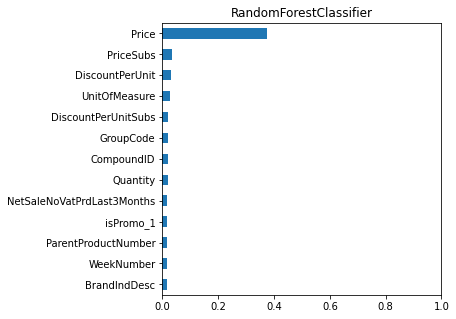

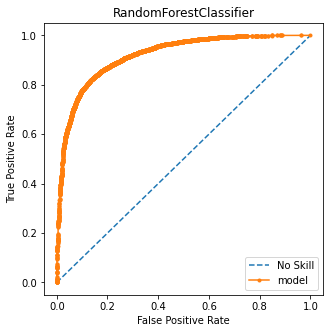

0  ...                                               note
name                          index          ...                                                   
RandomForestClassifier: Train 0      9087.0  ...  n_estimators=200, criterion='entropy', max_dep...
                              1      1319.0  ...                                                   
RandomForestClassifier: Test  0      3674.0  ...  n_estimators=200, criterion='entropy', max_dep...
                              1       760.0  ...                                                   

[4 rows x 11 columns]

no diff


In [56]:
ONLY_RF = True
df_result = pd.DataFrame()

if not ONLY_RF:
  process_model(LogisticRegression(max_iter=1000), X_train, y_train, X_test, y_test, note='max_iter=1000', threshold=0.0000005)  # did not fit, return accuracy=0, so we increased max_iter from default 100
  process_model(LogisticRegression(C=100, max_iter=1000, fit_intercept=False, warm_start=True), X_train, y_train, X_test, y_test, note='max_iter=1000, C=100, fit_intercept=False, warm_start=True', threshold=0.0000005, plot=False)

  clf_GB = GradientBoostingClassifier(n_estimators=100)
  process_model(clf_GB, X_train, y_train, X_test, y_test, plot=False, threshold=0.015, note='n_estimators=100')
  clf_GB = GradientBoostingClassifier(ccp_alpha=0.0001, n_estimators=200, random_state=1234)
  process_model(clf_GB, X_train, y_train, X_test, y_test, plot=False, threshold=0.015, note='ccp_alpha=0.0001, n_estimators=200, random_state=1234')

  #process_model(AdaBoostClassifier(n_estimators=100))  # base estimator is DecisionTreeClassifier initialized with max_depth=1
  clf_AB = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5), n_estimators=100, learning_rate=0.01)
  process_model(clf_AB, X_train, y_train, X_test, y_test)

  process_model(KNeighborsClassifier(n_neighbors=39), X_train, y_train, X_test, y_test)

  if not REL: #ERROR: Classification metrics can't handle a mix of binary and continuous targets
    process_model(VotingClassifier(estimators=[('RF', clf_RF), ('GB', clf_GB), ('AB', clf_AB)], voting='soft'), X_train, y_train, X_test, y_test, note="('RF', clf_RF), ('GB', clf_GB), ('AB', clf_AB')")

  if False: ## too long > 4 minutes
    process_model(LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.0001, C=0.1, max_iter=20000)) # max_iter increaed from default 1000 to 3000, 6000, 20000 because did not coverged warning
    from sklearn import svm
    process_model(svm.SVC())

clf_RF = RandomForestClassifier(n_estimators=200, criterion='entropy', max_depth=None, min_samples_split=20, ccp_alpha=0.0003, random_state=73)
process_model(clf_RF, X_train, y_train, X_test, y_test, plot=True, threshold=0.015, note="n_estimators=200, criterion='entropy', max_depth=None, min_samples_split=20, ccp_alpha=0.0003, random_state=1234")

d(df_result)

fname = prefix + f'_result_{id}.csv'
df_result.to_csv(fname, index = True)
p(id)

## Models - compare results

1. Diff
2. Diff with remove ingredients columns
3. Diff with split based on date
3. Diff with split based on date (without date features and order info) 
4. Ratio
5. RelDiff - relative difference
6. OnlyPrices - Diff with only 3 features( Price, PriceSubs, PriceDiff)
8. No Diff (no comparison between master and subs)

In [57]:
def read_results(id='', disp=True, full=False):
  fname = prefix + f'_result_{id}.csv'
  p(fname)
  try:
    df = pd.read_csv(fname)
  except:
    try:
      df = get_raw(fname, 'Results/')
#      df = pd.read_csv(fname)
    except:
      p('No data')
      return
  df.set_index(['name', 'index'], inplace=True)
  if not full:
    df = df.loc[['RandomForestClassifier: Train', 'RandomForestClassifier: Test']]#.copy()
  if disp:
    pd.set_option("max_column", 120)
    d(df)
  return df

In [82]:
p(id)
read_results()
read_results('remove_ingredients')
read_results('split_based_on_date')
read_results('split_based_on_date_without_date_features_and_order_info')
read_results('ratio')
read_results('rel_diff')
read_results('only_prices')
read_results('no_diff')
p()

no diff
Shufersal_result_.csv


0        1  precision  recall  \
name                          index                                       
RandomForestClassifier: Train 0      9267.0   3382.0       0.86    0.73   
                              1      1546.0  23927.0       0.88    0.94   
RandomForestClassifier: Test  0      3804.0   1615.0       0.81    0.70   
                              1       879.0  10040.0       0.86    0.92   

                                     f1-score  accuracy  support  \
name                          index                                
RandomForestClassifier: Train 0          0.79      0.87  12649.0   
                              1          0.91      0.87  25473.0   
RandomForestClassifier: Test  0          0.75      0.85   5419.0   
                              1          0.89      0.85  10919.0   

                                     precision_avg  recall_avg  f1-score_avg  \
name                          index                                            
RandomForestClassifier: Train 0               0.87        0.84          0.85   
                              1               0.87        0.84          0.85   
RandomForestClassifier: Test  0               0.84        0.81          0.82   
                              1               0.84        0.81          0.82   

                                                                                  note  
name                          index                                                     
RandomForestClassifier: Train 0      n_estimators=200, criterion='entropy', max_dep...  
                              1                                                    NaN  
RandomForestClassifier: Test  0      n_estimators=200, criterion='entropy', max_dep...  
                              1                                                    NaN

Shufersal_result_remove_ingredients.csv


0        1  precision  recall  \
name                          index                                       
RandomForestClassifier: Train 0      9116.0   3533.0       0.86    0.72   
                              1      1512.0  23961.0       0.87    0.94   
RandomForestClassifier: Test  0      3767.0   1652.0       0.82    0.70   
                              1       828.0  10091.0       0.86    0.92   

                                     f1-score  accuracy  support  \
name                          index                                
RandomForestClassifier: Train 0          0.78      0.87  12649.0   
                              1          0.90      0.87  25473.0   
RandomForestClassifier: Test  0          0.75      0.85   5419.0   
                              1          0.89      0.85  10919.0   

                                     precision_avg  recall_avg  f1-score_avg  \
name                          index                                            
RandomForestClassifier: Train 0               0.86        0.83          0.84   
                              1               0.86        0.83          0.84   
RandomForestClassifier: Test  0               0.84        0.81          0.82   
                              1               0.84        0.81          0.82   

                                                                                  note  
name                          index                                                     
RandomForestClassifier: Train 0      n_estimators=200, criterion='entropy', max_dep...  
                              1                                                    NaN  
RandomForestClassifier: Test  0      n_estimators=200, criterion='entropy', max_dep...  
                              1                                                    NaN

Shufersal_result_split_based_on_date.csv


0        1  precision  recall  \
name                          index                                       
RandomForestClassifier: Train 0      8644.0   3102.0       0.86    0.74   
                              1      1419.0  24252.0       0.89    0.94   
RandomForestClassifier: Test  0      3699.0   2623.0       0.78    0.59   
                              1      1072.0   9649.0       0.79    0.90   

                                     f1-score  accuracy  support  \
name                          index                                
RandomForestClassifier: Train 0          0.79      0.88  11746.0   
                              1          0.91      0.88  25671.0   
RandomForestClassifier: Test  0          0.67      0.78   6322.0   
                              1          0.84      0.78  10721.0   

                                     precision_avg  recall_avg  f1-score_avg  \
name                          index                                            
RandomForestClassifier: Train 0               0.87        0.84          0.85   
                              1               0.87        0.84          0.85   
RandomForestClassifier: Test  0               0.78        0.74          0.75   
                              1               0.78        0.74          0.75   

                                                                                  note  
name                          index                                                     
RandomForestClassifier: Train 0      n_estimators=200, criterion='entropy', max_dep...  
                              1                                                    NaN  
RandomForestClassifier: Test  0      n_estimators=200, criterion='entropy', max_dep...  
                              1                                                    NaN

Shufersal_result_split_based_on_date_without_date_features_and_order_info.csv


0        1  precision  recall  \
name                          index                                       
RandomForestClassifier: Train 0      8386.0   3360.0       0.84    0.71   
                              1      1569.0  24102.0       0.88    0.94   
RandomForestClassifier: Test  0      3685.0   2637.0       0.78    0.58   
                              1      1042.0   9679.0       0.79    0.90   

                                     f1-score  accuracy  support  \
name                          index                                
RandomForestClassifier: Train 0          0.77      0.87  11746.0   
                              1          0.91      0.87  25671.0   
RandomForestClassifier: Test  0          0.67      0.78   6322.0   
                              1          0.84      0.78  10721.0   

                                     precision_avg  recall_avg  f1-score_avg  \
name                          index                                            
RandomForestClassifier: Train 0               0.86        0.83          0.84   
                              1               0.86        0.83          0.84   
RandomForestClassifier: Test  0               0.78        0.74          0.75   
                              1               0.78        0.74          0.75   

                                                                                  note  
name                          index                                                     
RandomForestClassifier: Train 0      n_estimators=200, criterion='entropy', max_dep...  
                              1                                                    NaN  
RandomForestClassifier: Test  0      n_estimators=200, criterion='entropy', max_dep...  
                              1                                                    NaN

Shufersal_result_ratio.csv


0        1  precision  recall  \
name                          index                                       
RandomForestClassifier: Train 0      9227.0   3422.0       0.85    0.73   
                              1      1586.0  23887.0       0.87    0.94   
RandomForestClassifier: Test  0      3797.0   1622.0       0.81    0.70   
                              1       899.0  10020.0       0.86    0.92   

                                     f1-score  accuracy  support  \
name                          index                                
RandomForestClassifier: Train 0          0.79      0.87  12649.0   
                              1          0.91      0.87  25473.0   
RandomForestClassifier: Test  0          0.75      0.85   5419.0   
                              1          0.89      0.85  10919.0   

                                     precision_avg  recall_avg  f1-score_avg  \
name                          index                                            
RandomForestClassifier: Train 0               0.86        0.83          0.85   
                              1               0.86        0.83          0.85   
RandomForestClassifier: Test  0               0.83        0.81          0.82   
                              1               0.83        0.81          0.82   

                                                                                  note  
name                          index                                                     
RandomForestClassifier: Train 0      n_estimators=200, criterion='entropy', max_dep...  
                              1                                                    NaN  
RandomForestClassifier: Test  0      n_estimators=200, criterion='entropy', max_dep...  
                              1                                                    NaN

Shufersal_result_rel_diff.csv


0        1  precision  recall  \
name                          index                                       
RandomForestClassifier: Train 0      9280.0   3369.0       0.86    0.73   
                              1      1567.0  23906.0       0.88    0.94   
RandomForestClassifier: Test  0      3829.0   1590.0       0.81    0.71   
                              1       899.0  10020.0       0.86    0.92   

                                     f1-score  accuracy  support  \
name                          index                                
RandomForestClassifier: Train 0          0.79      0.87  12649.0   
                              1          0.91      0.87  25473.0   
RandomForestClassifier: Test  0          0.75      0.85   5419.0   
                              1          0.89      0.85  10919.0   

                                     precision_avg  recall_avg  f1-score_avg  \
name                          index                                            
RandomForestClassifier: Train 0               0.87        0.84          0.85   
                              1               0.87        0.84          0.85   
RandomForestClassifier: Test  0               0.84        0.81          0.82   
                              1               0.84        0.81          0.82   

                                                                                  note  
name                          index                                                     
RandomForestClassifier: Train 0      n_estimators=200, criterion='entropy', max_dep...  
                              1                                                    NaN  
RandomForestClassifier: Test  0      n_estimators=200, criterion='entropy', max_dep...  
                              1                                                    NaN

Shufersal_result_only_prices.csv


0        1  precision  recall  \
name                          index                                       
RandomForestClassifier: Train 0      8819.0   3830.0       0.77    0.70   
                              1      2709.0  22764.0       0.86    0.89   
RandomForestClassifier: Test  0      3786.0   1633.0       0.75    0.70   
                              1      1234.0   9685.0       0.86    0.89   

                                     f1-score  accuracy  support  \
name                          index                                
RandomForestClassifier: Train 0          0.73      0.83  12649.0   
                              1          0.87      0.83  25473.0   
RandomForestClassifier: Test  0          0.73      0.82   5419.0   
                              1          0.87      0.82  10919.0   

                                     precision_avg  recall_avg  f1-score_avg  \
name                          index                                            
RandomForestClassifier: Train 0               0.81        0.80           0.8   
                              1               0.81        0.80           0.8   
RandomForestClassifier: Test  0               0.80        0.79           0.8   
                              1               0.80        0.79           0.8   

                                                                                  note  
name                          index                                                     
RandomForestClassifier: Train 0      n_estimators=200, criterion='entropy', max_dep...  
                              1                                                    NaN  
RandomForestClassifier: Test  0      n_estimators=200, criterion='entropy', max_dep...  
                              1                                                    NaN

Shufersal_result_no_diff.csv


0        1  precision  recall  \
name                          index                                       
RandomForestClassifier: Train 0      9074.0   3575.0       0.87    0.72   
                              1      1353.0  24120.0       0.87    0.95   
RandomForestClassifier: Test  0      3657.0   1762.0       0.83    0.67   
                              1       770.0  10149.0       0.85    0.93   

                                     f1-score  accuracy  support  \
name                          index                                
RandomForestClassifier: Train 0          0.79      0.87  12649.0   
                              1          0.91      0.87  25473.0   
RandomForestClassifier: Test  0          0.74      0.85   5419.0   
                              1          0.89      0.85  10919.0   

                                     precision_avg  recall_avg  f1-score_avg  \
name                          index                                            
RandomForestClassifier: Train 0               0.87        0.83          0.85   
                              1               0.87        0.83          0.85   
RandomForestClassifier: Test  0               0.84        0.80          0.82   
                              1               0.84        0.80          0.82   

                                                                                  note  
name                          index                                                     
RandomForestClassifier: Train 0      n_estimators=200, criterion='entropy', max_dep...  
                              1                                                    NaN  
RandomForestClassifier: Test  0      n_estimators=200, criterion='entropy', max_dep...  
                              1                                                    NaN

#Baseline Model

In [ ]:
def returnPrec(model,products):
            productCols=['ParentProductNumber','ParentProductNumberSubs']
            val=model[(model[productCols[0]]==products[0]) & (model[productCols[1]]==products[1])]['avgApproval']
            if val.empty ==False:
                #display(val)
                return val.iloc[0]
            #print(val)
            return -1

In [ ]:
class BaselineModel:
    def __init__(self, classes_):
        self.classes_ = classes_
    def fit(self,X_, y_):
        #catalogCols=['ParentProductNumber','CompoundID','SubGroupCodeNew','GroupCode']
        cols=['ParentProductNumber','ParentProductNumberSubs']
        group=pd.concat([X_[cols],y_],axis=1).apply(lambda x:x.astype(np.int64))\
            .groupby(cols)\
            .agg({'CorrelateItemStatusCode':[('avgApproval','mean'),('countRows','count')]}).reset_index()
        group.columns=group.columns.droplevel(0)
        group.columns.values[0]=cols[0]
        group.columns.values[1]=cols[1]
        group=group[group['countRows']>=5]
        display(group.head())
        display(len(group))
        self.model=group 
        return self
    
    def predict(self,X_): 
        #print(type(X_))
        y_predPrec = X_.apply(lambda x: returnPrec( model=self.model,products=[x['ParentProductNumber'],
                                                                                 x['ParentProductNumberSubs']]),axis=1)
        #display(y_predPrec)
        y_pred=np.where(y_predPrec>0.5,1,0)
        return y_pred
    def predict_proba(self,X_):
        y_predPrec = X_.apply(lambda x: returnPrec(model=self.model, products=[x['ParentProductNumber'],
                                                                                 x['ParentProductNumberSubs']]),axis=1)
        return y_predPrec

In [ ]:
baseline=BaselineModel(df.CorrelateItemStatusCode.unique())

In [ ]:
baseline.fit(X_train,y_train)

,ParentProductNumber,ParentProductNumberSubs,avgApproval,countRows
0,161631,161648,0.88,34
1,161631,72909799,0.92,64
8,161631,7290112497918,0.93,14
9,161648,161631,0.92,53
10,161648,72909799,0.96,48


1289

In [ ]:
y_pred=baseline.predict(X_test)

##Example baseline model

In [ ]:
y_train[(X_train['ParentProductNumber']==161631) & (X_train['ParentProductNumberSubs']==72909799)].sum()\
/len(y_train[(X_train['ParentProductNumber']==161631) & (X_train['ParentProductNumberSubs']==72909799)])

0.921875

In [ ]:
baseline.predict_proba(X_test[(X_test['ParentProductNumber']==161631) & (X_test['ParentProductNumberSubs']==72909799)])

345      0.92
4927     0.92
16358    0.92
41198    0.92
25464    0.92
52381    0.92
12346    0.92
34919    0.92
4408     0.92
46446    0.92
7792     0.92
6269     0.92
30101    0.92
3085     0.92
21205    0.92
20330    0.92
16116    0.92
16446    0.92
26106    0.92
42864    0.92
18457    0.92
47503    0.92
dtype: float64

In [ ]:
print(len(y_pred[y_pred==0]))
print(len(y_pred[y_pred==1]))
print(len(y_pred[y_pred==-1]))

4908
11430
0


In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.52      0.47      0.50      5419
           1       0.75      0.79      0.77     10919

    accuracy                           0.68     16338
   macro avg       0.64      0.63      0.63     16338
weighted avg       0.68      0.68      0.68     16338



In [ ]:
process_model(BaselineModel(df.CorrelateItemStatusCode.unique()))

Result of running the models - no improvemnet using the dummies: shape = (54460, 2238)

running:  LogisticRegression
running:  LogisticRegression
running:  GradientBoostingClassifier
running:  GradientBoostingClassifier
running:  AdaBoostClassifier
running:  RandomForestClassifier
running:  KNeighborsClassifier
running:  VotingClassifier
0	1	precision	recall	f1-score	accuracy	support	precision_avg	recall_avg	f1-score_avg	note
name	index											
LogisticRegression: Train	0	0.0	12649.0	1.00	0.00	0.00	0.67	12649.0	0.83	0.50	0.40	max_iter=1000
1	0.0	25473.0	0.67	1.00	0.80	0.67	25473.0	0.83	0.50	0.40	
LogisticRegression: Test	0	0.0	5419.0	1.00	0.00	0.00	0.67	5419.0	0.83	0.50	0.40	max_iter=1000
1	0.0	10919.0	0.67	1.00	0.80	0.67	10919.0	0.83	0.50	0.40	
LogisticRegression: Train	0	0.0	12649.0	1.00	0.00	0.00	0.67	12649.0	0.83	0.50	0.40	max_iter=1000, C=100, fit_intercept=False, war...
1	0.0	25473.0	0.67	1.00	0.80	0.67	25473.0	0.83	0.50	0.40	
LogisticRegression: Test	0	0.0	5419.0	1.00	0.00	0.00	0.67	5419.0	0.83	0.50	0.40	max_iter=1000, C=100, fit_intercept=False, war...
1	0.0	10919.0	0.67	1.00	0.80	0.67	10919.0	0.83	0.50	0.40	
GradientBoostingClassifier: Train	0	7748.0	4901.0	0.79	0.61	0.69	0.82	12649.0	0.81	0.77	0.78	n_estimators=100
1	2006.0	23467.0	0.83	0.92	0.87	0.82	25473.0	0.81	0.77	0.78	
GradientBoostingClassifier: Test	0	3326.0	2093.0	0.78	0.61	0.69	0.82	5419.0	0.81	0.76	0.78	n_estimators=100
1	917.0	10002.0	0.83	0.92	0.87	0.82	10919.0	0.81	0.76	0.78	
GradientBoostingClassifier: Train	0	12649.0	0.0	1.00	1.00	1.00	1.00	12649.0	1.00	1.00	1.00	max_depth=None, max_leaf_nodes=None, min_sampl...
1	0.0	25473.0	1.00	1.00	1.00	1.00	25473.0	1.00	1.00	1.00	
GradientBoostingClassifier: Test	0	4128.0	1291.0	0.82	0.76	0.79	0.86	5419.0	0.85	0.84	0.84	max_depth=None, max_leaf_nodes=None, min_sampl...
1	936.0	9983.0	0.89	0.91	0.90	0.86	10919.0	0.85	0.84	0.84	
AdaBoostClassifier: Train	0	7352.0	5297.0	0.78	0.58	0.67	0.81	12649.0	0.80	0.75	0.76	
1	2095.0	23378.0	0.82	0.92	0.86	0.81	25473.0	0.80	0.75	0.76	
AdaBoostClassifier: Test	0	3167.0	2252.0	0.77	0.58	0.66	0.80	5419.0	0.79	0.75	0.76	
1	955.0	9964.0	0.82	0.91	0.86	0.80	10919.0	0.79	0.75	0.76	
RandomForestClassifier: Train	0	7366.0	5283.0	0.86	0.58	0.69	0.83	12649.0	0.84	0.77	0.79	n_estimators=200, criterion='entropy', max_dep...
1	1243.0	24230.0	0.82	0.95	0.88	0.83	25473.0	0.84	0.77	0.79	
RandomForestClassifier: Test	0	2971.0	2448.0	0.82	0.55	0.66	0.81	5419.0	0.81	0.74	0.76	n_estimators=200, criterion='entropy', max_dep...
1	669.0	10250.0	0.81	0.94	0.87	0.81	10919.0	0.81	0.74	0.76	
KNeighborsClassifier: Train	0	2262.0	10387.0	0.58	0.18	0.27	0.68	12649.0	0.64	0.56	0.54	
1	1652.0	23821.0	0.70	0.94	0.80	0.68	25473.0	0.64	0.56	0.54	
KNeighborsClassifier: Test	0	858.0	4561.0	0.51	0.16	0.24	0.67	5419.0	0.60	0.54	0.52	
1	824.0	10095.0	0.69	0.92	0.79	0.67	10919.0	0.60	0.54	0.52	
VotingClassifier: Train	0	12235.0	414.0	1.00	0.97	0.98	0.99	12649.0	0.99	0.98	0.99	('RF', clf_RF), ('GB', clf_GB), ('AB', clf_AB')
1	0.0	25473.0	0.98	1.00	0.99	0.99	25473.0	0.99	0.98	0.99	
VotingClassifier: Test	0	4005.0	1414.0	0.83	0.74	0.78	0.86	5419.0	0.86	0.83	0.84	('RF', clf_RF), ('GB', clf_GB), ('AB', clf_AB')
1	799.0	10120.0	0.88	0.93	0.90	0.86	10919.0	0.86	0.83	0.84	

# Grid Search for hyperparameters - on best model RandonForest

It run for few hours and then colab disconnected - it was to preform 5880 checks. From the partial results (because Verbose=4) I saw that n_estimators=500, min_samples_split=6, criterion='entropy' gives better results so we implemented them and we can see that indeed precision was improved from 84% to 85% 

In [59]:
GS = False
if GS and False:
  clf_RF = RandomForestClassifier(n_estimators=64)
  clf_RF.fit(X_train, y_train)
  p(clf_RF.score(X_train, y_train))
  p(clf_RF.score(X_test, y_test))

In [60]:
def run_GS(model, param_grid, n_jobs=-1, cv=5, verbose=4):
  if verbose > 3 and n_jobs == -1:
    p('Warning: when n_jobs=-1 no partial results are displayed')
    p('Change one of the parameters - Aborted')
    return
  clf_gs = GridSearchCV(model, param_grid, cv=cv, verbose=verbose, n_jobs=n_jobs)
  clf_gs.fit(X_train, y_train)

  p('Results')
  clf_gs.estimator
  p(clf_gs.best_params_)
  p(clf_gs.best_estimator_)
  p('After')
  p(clf_gs.score(X_train, y_train))
  p(clf_gs.score(X_test, y_test))

In [61]:
if GS and False:
  param_grid = { 
      'max_depth' : [None, 8, 15],
      'ccp_alpha': [0.0001, 0.0003, 0.0005],
      'n_estimators': [100, 200],
  #    'max_features': ['auto', 'sqrt', 'log2', 1.0, 0.75, 0.5, 0.25],
      'max_leaf_nodes': [None, 20, 40],
      'min_samples_split': [2, 10, 20],
      'random_state': [73]
  }
  model = GradientBoostingClassifier()
  run_GS(model, param_grid, n_jobs=-1, cv=2, verbose=3)

In [62]:
if GS:
  param_grid = { 
#      'max_depth' : [None, 8, 15],
      'ccp_alpha': [0.0008, 0.001, 0.002],
      #'n_estimators': [100],
  #    'max_features': ['auto', 'sqrt', 'log2', 1.0, 0.75, 0.5, 0.25],
#      'max_leaf_nodes': [None, 20, 40],
      'min_samples_split': [2],
      'random_state': [73]
  }
  model = GradientBoostingClassifier()
  run_GS(model, param_grid, n_jobs=-1, cv=2, verbose=3)

Results
{'ccp_alpha': 0.0005, 'max_depth': None, 'max_leaf_nodes': None, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 73}
GradientBoostingClassifier(ccp_alpha=0.0005, criterion='friedman_mse',
                           init=None, learning_rate=0.1, loss='deviance',
                           max_depth=None, max_features=None,
                           max_leaf_nodes=None, min_impurity_decrease=0.0,
                           min_impurity_split=None, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           presort='deprecated', random_state=73, subsample=1.0,
                           tol=0.0001, validation_fraction=0.1, verbose=0,
                           warm_start=False)

After

0.8204559424860357

0.764712785307751


In [63]:
if GS:
  param_grid = { 
      'max_depth' : [None, 8, 15],
      'ccp_alpha': [0.0001, 0.0003, 0.0005],
      'n_estimators': [100, 200],
  #    'max_features': ['auto', 'sqrt', 'log2', 1.0, 0.75, 0.5, 0.25],
      'criterion' :['gini', 'entropy'], 
      'max_leaf_nodes': [None, 20, 40],
      'min_samples_split': [2, 10, 20],
      'random_state': [73]
  }
  model = RandomForestClassifier()
  run_GS(model, param_grid, n_jobs=-1, cv=2, verbose=3)

In [64]:
if GS:
  param_grid = { 
      'max_depth' : [None, 4,5,6,7,8],
      'ccp_alpha': [0.01, 0.02, 0.03, 0.1],
  #    'n_estimators': [64, 200, 500],
  #    'max_features': ['auto', 'sqrt', 'log2', 1.0, 0.75, 0.5, 0.25],
      'criterion' :['gini', 'entropy'], 
  #   'max_leaf_nodes': [None, 4, 10, 20],
      'min_samples_split': [20, 100, 500]#[2, 4, 6, 8, 10, 12, 14]
  }
  model = RandomForestClassifier()
  run_GS(model, param_grid, n_jobs=-1, cv=2, verbose=3)

In [65]:
if GS and False:
  param_grid = { 
      'max_depth' : [None, 4,8,10],
      'ccp_alpha': [0.005, 0.01, 0.015],
  #    'n_estimators': [64, 200, 500],
  #    'max_features': ['auto', 'sqrt', 'log2', 1.0, 0.75, 0.5, 0.25],
      'criterion' :['entropy'], 
  #   'max_leaf_nodes': [None, 4, 10, 20],
      'min_samples_split': [10, 20, 30]
  }

  model = RandomForestClassifier()
  run_GS(model, param_grid, n_jobs=-1, cv=2, verbose=3)

> output:

Fitting 5 folds for each of 144 candidates, totalling 720 fits

{'ccp_alpha': 0.01, 'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 20}

In [66]:
if GS and False:
  param_grid = { 
      'max_depth' : [None, 4,8,10],
      'ccp_alpha': [0.005, 0.01, 0.015],
  #    'n_estimators': [64, 200, 500],
  #    'max_features': ['auto', 'sqrt', 'log2', 1.0, 0.75, 0.5, 0.25],
      'criterion' :['entropy'], 
  #   'max_leaf_nodes': [None, 4, 10, 20],
      'min_samples_split': [10, 20, 30]
  }

  model = RandomForestClassifier()
  run_GS(model, param_grid, n_jobs=-1, cv=2, verbose=3)

> Output

Fitting 5 folds for each of 36 candidates, totalling 180 fits

{'ccp_alpha': 0.005, 'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 20}

Train: 0.7725460364094224

Test: 0.7751866813563472

In [67]:
if GS and False:
  param_grid = { 
      'max_depth' : [None],
      'ccp_alpha': [0.001, 0.003, 0.005],
      'criterion' :['entropy'], 
      'min_samples_split': [20],
      'n_estimators': [64, 200, 500],
  }
  model = RandomForestClassifier()
  run_GS(model, param_grid, n_jobs=-1, cv=2, verbose=3)

> Output

Fitting 5 folds for each of 9 candidates, totalling 45 fits

{'ccp_alpha': 0.001, 'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 20, 'n_estimators': 200}

Train: 0.8159592885997586

Test: 0.8142367486840495

In [68]:
if GS and False:
  param_grid = { 
      'max_depth' : [None],
      'ccp_alpha': [0.0001, 0.0005, 0.0008, 0.001],
      'criterion' :['entropy'], 
      'min_samples_split': [20],
      'n_estimators': [200, 300],
  }
  model = RandomForestClassifier()
  run_GS(model, param_grid, n_jobs=-1, cv=2, verbose=3)

> Output

Fitting 5 folds for each of 8 candidates, totalling 40 fits (15 mins)

{'ccp_alpha': 0.0001, 'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 20, 'n_estimators': 200}

Train: 0.921698756623472

Test: 0.8595299302240176

In [69]:
if GS and False:
  clf_RF = RandomForestClassifier(n_estimators=200, criterion='entropy', max_depth=None, min_samples_split=20, ccp_alpha=0.0005)
  clf_RF.fit(X_train, y_train)
  p(clf_RF.score(X_train, y_train))
  p(clf_RF.score(X_test, y_test))

In [70]:
#{'ccp_alpha': 0.0005, 'criterion': 'gini', 'max_depth': None, 'max_leaf_nodes': None, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 73}

if GS:
  for i in range(5):
    ccp_alpha = 0.0001 + i / 10000
    clf_RF = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, ccp_alpha=ccp_alpha, random_state=73)
    p(ccp_alpha)
    clf_RF.fit(X_train, y_train)
    p(clf_RF.score(X_train, y_train))
    p(clf_RF.score(X_test, y_test))

# Cross validation

In [71]:
CV = False
if CV:
  k = 7
  scores = cross_val_score(clf_RF, X_train, y_train, cv=k)
  p("\nscores : " + (k * "{:.3f}, ").format(*scores))
  p("mean : {:.3f} std : {:.3f} ".format(scores.mean(), scores.std()))

scores : 0.838, 0.845, 0.843, 0.850, 0.837, 0.844, 0.843, 

mean : 0.843 std : 0.004 

# TODO:

## Bagging (Bootstrap Aggregation)

> One classifier ("base model") and try to fit many different subsamples of the data

> The hyper-parameters "max_samples" and "max_features" control the size of the subsets

> The hyper-parameters "bootstrap" and "bootstrap_features" control wether the samples and the features are drawn with (or without) replacement

In [72]:
clf_base = DecisionTreeClassifier(max_depth=5)

In [73]:
clf_bagging = BaggingClassifier(base_estimator=clf_base, n_estimators=50)
clf_bagging.fit(X_train, y_train)

clf_bagging.score(X_train, y_train)
clf_bagging.score(X_test, y_test)

0.7534581956175787

## Correlation